# HAR Experiment using LSTM
- data source: combined data from Sean
    - subject names removed from file name. order is Timothy, Sean, Angelica
- preprocessing:
    1. remove pilot and null subcarriers
    2. split data by every 10 seconds
    3. standardise light data & CSI data
- split data into 60:20:20. (currently, there is a lack of data, so model very likely underfits)
- train model
- test model

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
os.getcwd()

'd:\\fyp_mds5\\model'

In [3]:
# define list of pilot and null subcarriers for 20MHz
pilot_carrier_cols =  ['csi_channel_' + str(x+32) for x in [-21, -7, 21,  7]]
null_carrier_cols =  ['csi_channel_' + str(x+32) for x in [-32, -31, -30, -29, 31,  30,  29,  0]]
remove_subcarrier_cols = pilot_carrier_cols + null_carrier_cols

## Read Activity Files

In [4]:
# generate iterator of jpg files in a list of directories
def data_files_iter(dir):
    for file in os.listdir(dir):
        if file.endswith(".csv"):
            fname = os.path.join(dir, file)
            components = fname.split("\\")[3]
            fname_tokens = components.split("_")
            label, idx = fname_tokens[0], fname_tokens[1]
            yield fname, label

In [5]:
file_lst = os.listdir(r"..\dataset\combined_data")

In [6]:
for fname, label in data_files_iter(r"..\dataset\combined_data"):
    print(fname, label)

..\dataset\combined_data\empty_1_combined.csv empty
..\dataset\combined_data\empty_2_combined.csv empty
..\dataset\combined_data\empty_3_combined.csv empty
..\dataset\combined_data\empty_4_combined.csv empty
..\dataset\combined_data\sit_1_combined.csv sit
..\dataset\combined_data\sit_2_combined.csv sit
..\dataset\combined_data\sit_3_combined.csv sit
..\dataset\combined_data\sit_4_combined.csv sit
..\dataset\combined_data\sit_5_combined.csv sit
..\dataset\combined_data\sit_6_combined.csv sit
..\dataset\combined_data\sit_7_combined.csv sit
..\dataset\combined_data\sit_8_combined.csv sit
..\dataset\combined_data\sit_9_combined.csv sit
..\dataset\combined_data\stand_1_combined.csv stand
..\dataset\combined_data\stand_2_combined.csv stand
..\dataset\combined_data\stand_3_combined.csv stand
..\dataset\combined_data\stand_4_combined.csv stand
..\dataset\combined_data\stand_5_combined.csv stand
..\dataset\combined_data\stand_6_combined.csv stand
..\dataset\combined_data\stand_7_combined.csv st

In [7]:
df = pd.read_csv(fname)
df = df[df['time'].notna()] # take rows which have time values
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S.%f') # parse datetime string
df.head()

,time,1,2,3,4,5,6,7,8,9,...,csi_channel_246,csi_channel_247,csi_channel_248,csi_channel_249,csi_channel_250,csi_channel_251,csi_channel_252,csi_channel_253,csi_channel_254,csi_channel_255
0,2023-04-26 15:44:04.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-26 15:44:04.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-26 15:44:04.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-26 15:44:04.300,0.186154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-04-26 15:44:04.400,0.166330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
light_cols = ['time'] + [str(i) for i in range(9)]
csi_cols = ['time'] + [f'csi_channel_{i}' for i in range(64)]

In [9]:
light_df = df[light_cols]
csi_df = df[csi_cols]
for idx in range(0, 64):
    csi_col = f'csi_channel_{idx}'
    csi_df[csi_col] = csi_df[csi_col].apply(lambda x: np.abs(np.complex128(x)))

C:\Users\Timothy\AppData\Local\Temp\ipykernel_29340\2692265654.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csi_df[csi_col] = csi_df[csi_col].apply(lambda x: np.abs(np.complex128(x)))


In [10]:
light_df.head()

,time,0,1,2,3,4,5,6,7,8
0,2023-04-26 15:44:04.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-26 15:44:04.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-26 15:44:04.200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-26 15:44:04.300,NaN,0.186154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-04-26 15:44:04.400,NaN,0.166330,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Find the earliest time in the received time column
earliest_time = df['time'].min()

# Group the rows by every 10 seconds from the earliest time
grouped = df.groupby(pd.Grouper(key='time', freq='10S', origin=earliest_time))

# Loop through each group and do further processing
for name, group in grouped:
    print(f"Group: {name}")
    print(group.shape)

Group: 2023-04-26 15:44:04
(100, 267)
Group: 2023-04-26 15:44:14
(100, 267)
Group: 2023-04-26 15:44:24
(100, 267)
Group: 2023-04-26 15:44:34
(100, 267)
Group: 2023-04-26 15:44:44
(10, 267)


## Define function to read file

Assumed that every 10s contains
- 80 rows of csi data
- 100 rows of light data


In [154]:
# NOTE: main change
def read_combined_csv(fname, interval_sec=10):
    LIGHT_COLNAMES = [str(i) for i in range(9)]
    CSI_COLNAMES = [f'csi_channel_{i}' for i in range(64)]

    df = pd.read_csv(fname)
    df = df[df['time'].notna()] # take rows which have time values
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S.%f') # parse datetime string
    # fill missing light values
    df.loc[:, LIGHT_COLNAMES] =  df.loc[:, LIGHT_COLNAMES].ffill().bfill().fillna(1)

    # remove rows with time values that are too close to the start or end
    df = df[(df['time'] > df['time'].min() + pd.Timedelta(seconds=3)) & (df['time'] < df['time'].max() - pd.Timedelta(seconds=3))]

    # keep rows with csi data
    df = df[df['csi_channel_0'].notna()]

    # convert complex numbers to absolute values
    for idx in range(0, 64):
        csi_col = f'csi_channel_{idx}'
        df[csi_col] = df[csi_col].apply(lambda x: np.abs(np.complex128(x)))
    
    df = df[CSI_COLNAMES+LIGHT_COLNAMES] # reorder columns
    res = []
    total_groups = df.shape[0]//80 # set sample row size to 80 rows
    count = 0
    while count < total_groups:
        res.append(df.iloc[count*80:(count+1)*80, :].values)
        count += 1
    return res

In [155]:
# res = read_combined_csv(fname)
res = read_combined_csv(r"..\dataset\combined_data\stand_4_combined.csv")

In [156]:
len(res)

2

In [13]:
# for fname, lbl in data_files_iter(r"..\dataset\combined_data"):
#     a, b = read_combined_csv(fname)
#     print(f"{lbl} --------------------")
#     for csi, light in zip(a, b):
#         print(csi.shape, light.shape)

## Data Preparation

In [221]:
def read_files(activity_data):
    res = []
    for fname in activity_data:
        curr_dat = read_combined_csv(fname)
        for item in curr_dat:
            res.append(item)
    return res

def get_label(activity, label):
    list_y = []
    for i in range(len(activity)):
        list_y.append(label)
    return np.array(list_y).reshape(-1, 1) 

In [222]:
all_data_files = [(f, lbl) for f, lbl in data_files_iter(r"..\dataset\combined_data")]
empty_files = [tup[0] for tup in all_data_files if tup[1] == 'empty']
stand_files = [tup[0] for tup in all_data_files if tup[1] == 'stand']
sit_files = [tup[0] for tup in all_data_files if tup[1] == 'sit']
walk_files = [tup[0] for tup in all_data_files if tup[1] == 'walk']

In [223]:
empty_data = read_files(empty_files)
stand_data = read_files(stand_files)
sit_data = read_files(sit_files)
walk_data = read_files(walk_files)

empty_label = get_label(empty_data, 'empty')
stand_label = get_label(stand_data, 'stand')
sit_label = get_label(sit_data, 'sit')
walk_label = get_label(walk_data, 'walk')

In [224]:
np.unique(np.argwhere(np.isnan(stand_data))[:, 2])

array([], dtype=int64)

In [225]:
# concatenate all samples
X = np.vstack((empty_data, stand_data, sit_data, walk_data))
# concatenate all labels
y = np.vstack((empty_label, stand_label, sit_label, walk_label))

In [226]:
# randomise samples
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=5)

## Split train and test datasets

In [227]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

## Perform Data Standardisation

In [228]:
# Data Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin

class MinMax_Scaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

sc = MinMax_Scaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [229]:
## one-hot encode labels
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train).toarray()
y_test = ohe.transform(y_test).toarray()

## LSTM model

In [230]:
activity_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32, input_shape= X_train[-2,:].shape),#timestep and number of columns((500, 256)
    # tf.keras.layers.Dropout(rate=0.5), #for overfitting
    tf.keras.layers.Dense(units=16, activation='relu'), 
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')#Softmax converts a real vector to a vector of 
                                                                  #categorical probabilities
                                                                    # output shape (number of classes) 
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

opt = tf.keras.optimizers.Adam(learning_rate=1e-8)

activity_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


model_history = activity_model.fit(X_train, y_train, epochs= 300, validation_split=0.2,  batch_size=16, callbacks = [lr_schedule])

Epoch 1/300
3/3 [==============================] - 2s 178ms/step - loss: 1.3792 - accuracy: 0.2727 - val_loss: 1.4837 - val_accuracy: 0.1667 - lr: 1.0000e-08
Epoch 2/300
3/3 [==============================] - 0s 24ms/step - loss: 1.3792 - accuracy: 0.2727 - val_loss: 1.4837 - val_accuracy: 0.1667 - lr: 1.1220e-08
Epoch 3/300
3/3 [==============================] - 0s 25ms/step - loss: 1.3792 - accuracy: 0.2727 - val_loss: 1.4837 - val_accuracy: 0.1667 - lr: 1.2589e-08
Epoch 4/300
3/3 [==============================] - 0s 25ms/step - loss: 1.3792 - accuracy: 0.2727 - val_loss: 1.4837 - val_accuracy: 0.1667 - lr: 1.4125e-08
Epoch 5/300
3/3 [==============================] - 0s 25ms/step - loss: 1.3792 - accuracy: 0.2727 - val_loss: 1.4837 - val_accuracy: 0.1667 - lr: 1.5849e-08
Epoch 6/300
3/3 [==============================] - 0s 24ms/step - loss: 1.3792 - accuracy: 0.2727 - val_loss: 1.4837 - val_accuracy: 0.1667 - lr: 1.7783e-08
Epoch 7/300
3/3 [==============================] - 0s 27m

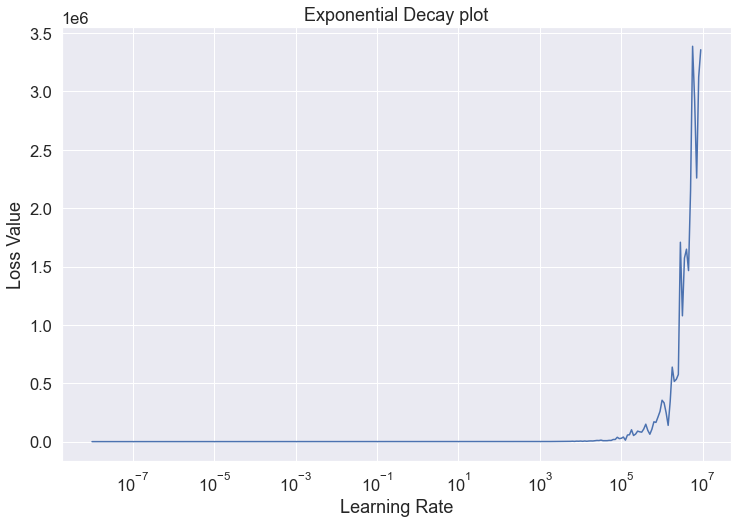

In [231]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# Exponential Decay Plot
figure(figsize=(12, 8))
plt.semilogx(model_history.history["lr"], np.array(model_history.history["loss"]))
sns.set(font_scale=1.5)
plt.ylabel('Loss Value')
plt.xlabel('Learning Rate')
plt.title('Exponential Decay plot')
plt.show()

In [232]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98):
            print("\nAccuracy has reached to threshold (98%) so stopping training!")
            self.model.stop_training = True

callbacks = myCallback()

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=32, input_shape= X_train[-2,:].shape),#timestep and number of columns((500, 256)
    # tf.keras.layers.Dropout(rate=0.5), #for overfitting
    tf.keras.layers.Dense(units=16, activation='relu'), 
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax'),#Softmax converts a real vector to a vector of 
                                                                  #categorical probabilities
                                                                    # output shape (number of classes) 
])
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [233]:
history = model.fit(X_train, y_train, epochs= 200, batch_size=16, validation_split = 0.2, callbacks = [callbacks, earlystopping])

Epoch 1/200
3/3 [==============================] - 2s 177ms/step - loss: 1.4056 - accuracy: 0.2727 - val_loss: 1.3171 - val_accuracy: 0.3333
Epoch 2/200
3/3 [==============================] - 0s 25ms/step - loss: 1.0596 - accuracy: 0.6818 - val_loss: 1.2835 - val_accuracy: 0.5000
Epoch 3/200
3/3 [==============================] - 0s 25ms/step - loss: 0.8832 - accuracy: 0.6818 - val_loss: 1.3065 - val_accuracy: 0.5000
Epoch 4/200
3/3 [==============================] - 0s 25ms/step - loss: 0.7062 - accuracy: 0.7045 - val_loss: 1.3227 - val_accuracy: 0.4167
Epoch 5/200
3/3 [==============================] - 0s 26ms/step - loss: 0.6049 - accuracy: 0.7500 - val_loss: 1.2441 - val_accuracy: 0.5833
Epoch 6/200
3/3 [==============================] - 0s 25ms/step - loss: 0.4830 - accuracy: 0.7500 - val_loss: 1.2083 - val_accuracy: 0.5833
Epoch 7/200
3/3 [==============================] - 0s 24ms/step - loss: 0.4054 - accuracy: 0.8409 - val_loss: 1.3156 - val_accuracy: 0.4167
Epoch 8/200
3/3 [==

In [234]:
y_pred = model.predict(X_test) #prediction on test data set

model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 18ms/step - loss: 4.4538 - accuracy: 0.4286


[4.4537763595581055, 0.4285714328289032]

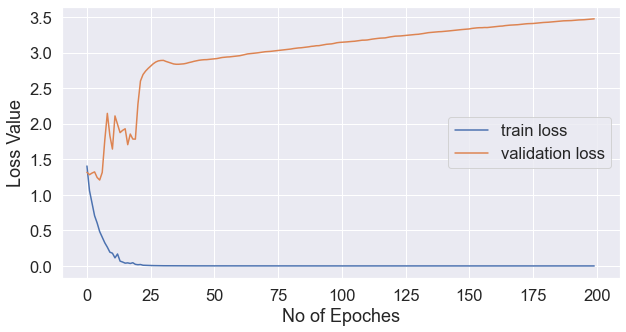

In [235]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylabel('Loss Value')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

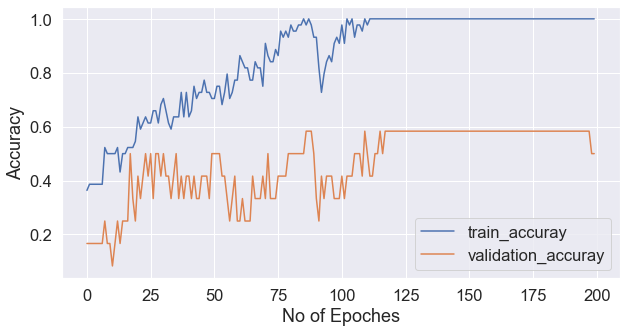

In [215]:
# plot history
figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of Epoches')
plt.legend()
plt.show()

In [236]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
index = ['Empty', 'sit', 'stand','walk']
columns = ['Empty', 'sit', 'stand','walk']
df_cm = pd.DataFrame(confusion_matrix,columns,index) 

Text(0.5, 16.421875, 'Predicted Activities')

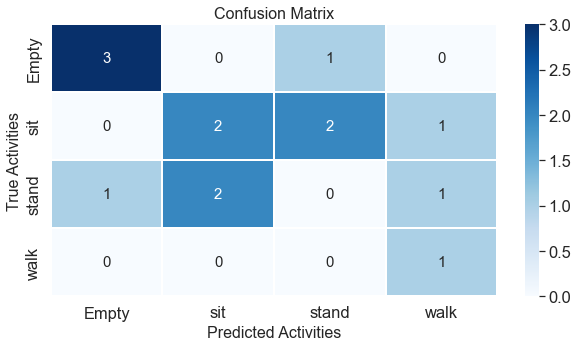

In [237]:
sns.set(font_scale=1.5)
figure(figsize=(10, 5))
sns.heatmap(df_cm, annot=True, cmap='Blues', linewidths=0.2,annot_kws={"fontsize":15})
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel('True Activities', fontsize=16)
plt.xlabel('Predicted Activities', fontsize=16)

In [238]:
from sklearn.metrics import classification_report
target_names = ['Empty', 'sit', 'stand','walk']
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names)) 

              precision    recall  f1-score   support

       Empty       0.75      0.75      0.75         4
         sit       0.50      0.40      0.44         5
       stand       0.00      0.00      0.00         4
        walk       0.33      1.00      0.50         1

    accuracy                           0.43        14
   macro avg       0.40      0.54      0.42        14
weighted avg       0.42      0.43      0.41        14

